<a id='title'></a>
# **Segmenting and Clustering Neighborhoods in Toronto**
---

### **Content**

- [Problem 1](#problem1)
- [Problem 2](#problem2)
- [Problem 3](#problem3)

---
<a id='problem1'></a>
### **Problem 1**

- The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
- Only process the cells that have an assigned borough. Ignore cells with a borough that is **Not assigned**.
- More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that **M5A** is listed twice and has two neighborhoods: **Harbourfront** and **Regent Park**. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in **row 11** in the above table.
- If a cell has a borough but a **Not assigned** neighborhood, then the neighborhood will be the same as the borough.
- Clean your Notebook and add Markdown cells to explain your work and any assumptions you are making.
- In the last cell of your notebook, use the **.shape** method to print the number of rows of your dataframe.

---

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import folium

# Web scraping the postal codes of Canada from Wikipedia page
url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup1 = BeautifulSoup(url,'lxml')

#Finding the html table
table = soup1.find('table')
print(table.prettify()[:1000])

<table cellpadding="2" cellspacing="0" rules="all" style="width:100%;">
 <tbody>
  <tr>
   <td style="width:11%;">
    <p>
     M1A
     <br/>
     <span style="font-size:85%;">
      Not assigned
     </span>
    </p>
   </td>
   <td style="width:11%;">
    <p>
     M2A
     <br/>
     <span style="font-size:85%;">
      Not assigned
     </span>
    </p>
   </td>
   <td style="width:11%;">
    <p>
     M3A
     <br/>
     <span style="font-size:85%;">
      <a href="/wiki/North_York" title="North York">
       North York
      </a>
      <br/>
      (
      <a href="/wiki/Parkwoods" title="Parkwoods">
       Parkwoods
      </a>
      )
     </span>
    </p>
   </td>
   <td style="width:11%;">
    <p>
     M4A
     <br/>
     <span style="font-size:85%;">
      <a href="/wiki/North_York" title="North York">
       North York
      </a>
      <br/>
      (
      <a href="/wiki/Victoria_Village" title="Victoria Village">
       Victoria Village
      </a>
      )
     </span>
    </p>


In [2]:
# Formatting web content as a table
table_contents = []
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

df = pd.DataFrame(table_contents)
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [3]:
# Replacing boroughs values
df['Borough']=df['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A'})
df['Borough']=df['Borough'].replace({'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business'})
df['Borough']=df['Borough'].replace({'EtobicokeNorthwest':'Etobicoke Northwest'})
df['Borough']=df['Borough'].replace({'East YorkEast Toronto':'East York/East Toronto'})
df['Borough']=df['Borough'].replace({'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})
df.head(20)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [4]:
# No rows with Neighborhood='Not assigned'
print('Number of rows with Neighborhood=\'Not assigned\':', len(df[df['Neighborhood']=='Not assigned']))

Number of rows with Neighborhood='Not assigned': 0


In [5]:
# Validating if a postal code is listed more than once
if len(df['PostalCode'].unique()) == len(df):
    print('No postal code is repeated')

No postal code is repeated


In [6]:
# CSV export
df.to_csv('List_of_postal_codes_of_Canada.csv', index=False)

In [7]:
df.shape

(103, 3)

[Go to top](#title)

---
<a id='problem2'></a>
### **Problem 2**

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

---

In [8]:
# Reading the resulting dataset from the previous problem
df = pd.read_csv('List_of_postal_codes_of_Canada.csv')
df.head()

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government


In [9]:
# Reading the geospatial dataset that contains latitude and longitude
ll_df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
ll_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [10]:
# Changing header name to match with df
ll_df.rename(columns={'Postal Code':'PostalCode'}, inplace=True)
ll_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
# Merging datasets
data = pd.merge(df, ll_df, on='PostalCode', how='left')
data

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto Business,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [12]:
# CSV export
data.to_csv('List_of_postal_codes_of_Canada_with_lat-lon.csv', index=False)

[Go to top](#title)

---
<a id='problem3'></a>
### **Problem 3**

Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you.

Just make sure:
1. to add enough Markdown cells to explain what you decided to do and to report any observations you make.
2. to generate maps to visualize your neighborhoods and how they cluster together.

---

In [13]:
# Getting rows in which field Borough contains "Toronto"

data_toronto = data[data['Borough'].str.contains('Toronto',regex=False)]
data_toronto.reset_index(drop=True, inplace=True)
data_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
3,M4E,East Toronto,The Beaches,43.676357,-79.293031
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259
9,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106


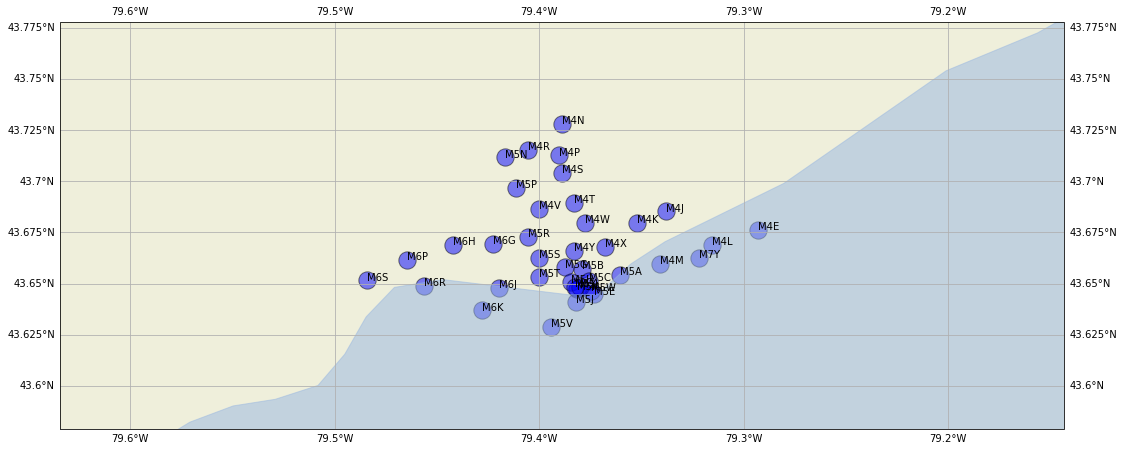

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
import cartopy.io.shapereader as shpreader
import io
from urllib.request import urlopen, Request
from PIL import Image

# Lower and upper longitude/latitude
llon = min(data_toronto["Longitude"]) -0.15
ulon = max(data_toronto["Longitude"]) +0.15
llat = min(data_toronto["Latitude"]) -0.05
ulat = max(data_toronto["Latitude"]) +0.05

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',                     # Category 'cultural' or 'physical'
        name='admin_1_states_provinces_lines',   # Name of dataset in http://www.naturalearthdata.com/
        scale='50m',
        facecolor='none')

# Plotting the map
map1 = plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())   #projection = type of map
ax.set_extent([llon, ulon, llat, ulat])        #coordinates of map
gridlines = ax.gridlines(draw_labels=True)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.COASTLINE)
#ax.add_feature(cfeature.RIVERS)
ax.add_feature(states_provinces, linestyle='dotted', edgecolor='gray')

# Visualization 1
for i in data_toronto.itertuples():
    ax.scatter(i.Longitude, i.Latitude, marker='o', s=300, color='blue', alpha = 0.5, edgecolors='black', linewidths=1, transform=ccrs.PlateCarree())
    plt.text(i.Longitude, i.Latitude, i.PostalCode)    #adds postal codes

In [15]:
# Clustering with 5 centroids
k = 5
toronto_clustering = data_toronto.drop(['PostalCode','Borough','Neighborhood'], 1)
kmeans = KMeans(n_clusters = k, random_state = 0).fit(toronto_clustering)
kmeans.labels_
data_toronto.insert(5, 'Cluster', kmeans.labels_)
data_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0
1,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,0
2,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0
3,M4E,East Toronto,The Beaches,43.676357,-79.293031,3
4,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0
5,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,0
6,M6G,Downtown Toronto,Christie,43.669542,-79.422564,2
7,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,0
8,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259,4
9,M4J,East York/East Toronto,The Danforth East,43.685347,-79.338106,3


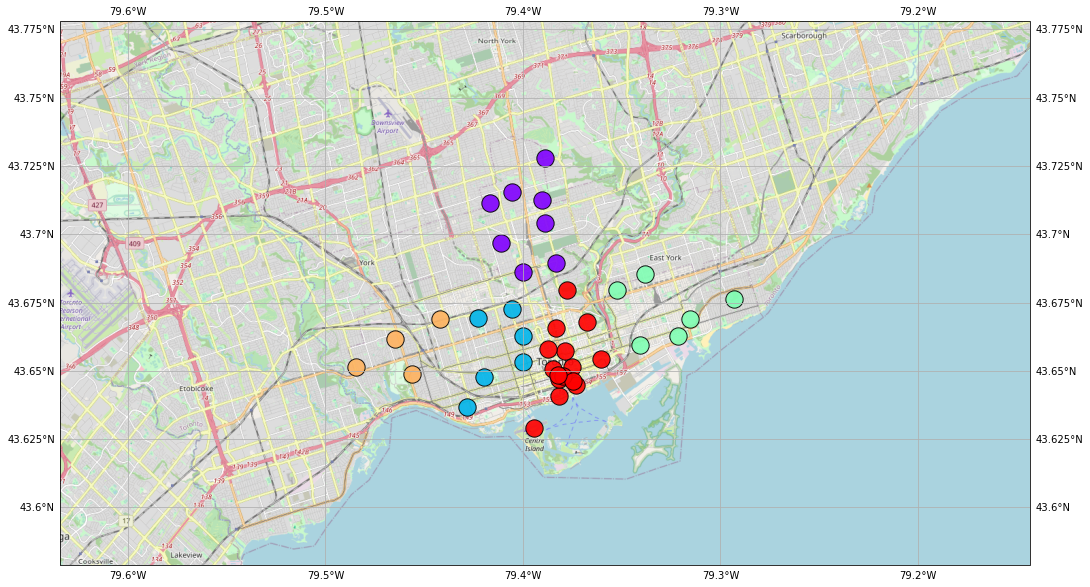

In [16]:
# This code uses a spoofing algorithm to avoid bounceback from OSM servers

def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
osm_img = cimgt.OSM() # spoofed, downloaded street map

# Setting color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Plotting the map
map2 = plt.figure(figsize=(18,10)) # open matplotlib figure
ax = plt.axes(projection=osm_img.crs)   #projection = type of map (using coordinate reference system (CRS) of street map)

ax.set_extent([llon, ulon, llat, ulat])        #coordinates

gridlines = ax.gridlines(draw_labels=True)    #gridlines

zoom = 0.1 # for zooming out of center point
scale = np.ceil(-np.sqrt(2)*np.log(np.divide(zoom,350.0))) # empirical solve for scale based on zoom
scale = (scale<20) and scale or 19 # scale cannot be larger than 19
ax.add_image(osm_img, int(scale)) # add OSM with zoom specification
# NOTE: zoom specifications should be selected based on extent:
# -- 2     = coarse image, select for worldwide or continental scales
# -- 4-6   = medium coarseness, select for countries and larger states
# -- 6-10  = medium fineness, select for smaller states, regions, and cities
# -- 10-12 = fine image, select for city boundaries and zip codes
# -- 14+   = extremely fine image, select for roads, blocks, buildings

#Visualization
for i in data_toronto.itertuples():
    ax.scatter(i.Longitude, i.Latitude, marker='o', s=300, color=rainbow[i.Cluster-1], alpha = 0.9, edgecolors='black', linewidths=1, transform=ccrs.PlateCarree())
    #plt.text(i.Longitude, i.Latitude, i.PostalCode)    #adds postal codes
plt.show()

[Go to top](#title)

---